# Radio Frequency Propagation using UDTF

The following example is a walk through to show how to use a complex User Defined Table Function (UDTF) on a large scale application.

*HeavyRF* is a SQL extension which can predict radio frequency (RF) signal strength (in dBm).

Predictions are based on "line of sight" using ray casting in which rays are considered blocked upon first contact with vegetation, buildings or terrain. Signal attenuation is modeled using [free-space path loss](https://en.wikipedia.org/wiki/Free-space_path_loss). This model is appropriate for "millimeter waves" such as 5G signals and similar high frequency signals. Future enhancements will extend the capabilities to a wider range of frequencies by taking into account vegetation attenuation and signal bouncing behavior.

*HeavyRF* provides the function `tf_rf_prop_max_signal`. Given a set of antenna/tower location and topography data (cloud point representing the buildings, vegeration, terrain), it builds the propagation model and makes the prediction.

```sql
tf_rf_prop_max_signal(
    rf_source => CURSOR(rf_source_id, rf_source_x, rf_source_y, rf_source_z),  /* cell tower data */
    rf_source_z_is_relative_to_terrain => TRUE,  /* AMSL elevation, otherwize with respect to ground */
    rf_source_signal_strength_dbm => 20.0,  /* source signal strength */
    rf_source_signal_frequency_mhz => 3900,  /* frequency of tower signal in MHz */
    terrain => CURSOR(terrain_x, terrain_y, terrain_z),  /* topography data */
    bin_dim_meters => 90,  /* output table size */
    max_ray_travel_meters => 2000,  /* max distance for signal strength computation */
    num_rays_per_sources => 720,  /* number of rays per source */
    min_receiver_signal_strength_dbm => -100.0  /* min receiver signal in dBm */
)
```

The output of the function is a table with predictions of signal power `rf_source_signal_strength_dbm` and the id of the nearest cell tower `rf_source_id`.

<div class="alert alert-block alert-info">
<b>Note:</b> When <code>geographic_coords => true</code>, the Coordinate Reference System (CRS) of the points' coordinates needs to be WGS84 (latitude, longitude). Otherwize, coordinates are assumed to be in meters (valid for a given UTM region). The elevation data is either referenced to the ground or the mean sea level (AMSL).
</div>

<div class="alert alert-block alert-info">
<b>Note:</b> Using named parameters in HeavyDB is supported with HeavyDB>=6. You can use previous versions by removing the annotation. E.g. <code>geographic_coords => true</code> would just be <code>true</code>.
</div>

## Setup

On top of *HeavyDB*, the following packages are used.

* [heavyai](https://heavyai.readthedocs.io/en/latest/): interact with HeavyDB
* [pandas](https://pandas.pydata.org): tabular data structure
* [s3fs](https://s3fs.readthedocs.io/): load s3 data
* [geopandas](https://geopandas.org/en/stable): geo-spatial plotting, helper functions on top of pandas
* [contextily](https://github.com/geopandas/contextily): background maps
* [matplotlib](https://matplotlib.org): plotting library
* [ipympl](https://github.com/matplotlib/ipympl): interactive matplotlib

They are all available on PyPi or conda-forge (recommended) depending on your prefered method of installation.

In [1]:
import heavyai
import pyarrow as pa
import geopandas as gpd
import contextily as cx
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import importlib_metadata
importlib_metadata.version('heavyai'), importlib_metadata.version('geopandas'), importlib_metadata.version('contextily')

('1.0', '0.9.0', '1.2.0')

In [3]:
%matplotlib widget

## Data preparation

To train our model, we have access to 2 dataset:

* A list of cell towers with some associated metadata
* A lidar survey of the region

First, connect to HeavyDB. This connection will be used to load, read data and execute commands on the database.

In [4]:
def create_connection():
    con = heavyai.connect(user="admin", password="HyperInteractive", host="localhost", dbname="heavyai")
    return con

con = create_connection()

### Importing data to HeavyDB

If the data is not yet present in the database, there are convenient functions to load pandas dataframe into HeavyDB.

Assuming our data is in CSV files, it can be loaded with pandas into dataframe:

In [5]:
lidar = pd.read_parquet("s3://mapd-data/telco/Lidar_Input.parquet", storage_options={"anon": True})
lidar.columns = ["x", "y", "z"]
cell_towers = pd.read_parquet("s3://mapd-data/telco/Cell_Towers_Input.parquet", storage_options={"anon": True})

In [6]:
lidar.head(1)

,x,y,z
0,-122.42375,37.78875,65.15439


In [7]:
cell_towers.head(1)

,radio,mcc,net,area,cell,unit,lon,lat,range_,samples,changeable,averageSignal,elevation,elevation0,repeater_id
0,LTE,310,260,51292,256263094,0,-122.41858,37.783684,1000,1,1,0,NaN,34.782833,220086


Create the two corresponding tables `lidar` and `cell_towers` on HeavyDB:

In [8]:
con.load_table("lidar", lidar)

In [9]:
con.load_table("cell_towers", cell_towers)

### Reading data from HeavyDB

Once the data is present on the database, it can be access or worked on using all the capabilities of HeavyDB.

In [10]:
con.get_tables()

['omnisci_states',
 'omnisci_counties',
 'omnisci_countries',
 'lidar',
 'cell_towers']

In [11]:
con.get_table_details('lidar')

[ColumnDetails(name='x', type='DOUBLE', nullable=True, precision=0, scale=0, comp_param=0, encoding='NONE', is_array=False),
 ColumnDetails(name='y', type='DOUBLE', nullable=True, precision=0, scale=0, comp_param=0, encoding='NONE', is_array=False),
 ColumnDetails(name='z', type='DOUBLE', nullable=True, precision=0, scale=0, comp_param=0, encoding='NONE', is_array=False)]

In [12]:
lidar = pd.read_sql("SELECT * FROM lidar", con)

/opt/homebrew/Caskroom/mambaforge/base/envs/heavyai-env/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [13]:
lidar.head(1)

,x,y,z
0,-122.42375,37.78875,65.15439


The data is conveniently read using a pandas dataframe which allows powerfull analysis.

But `heavyai` provides a more powerful method `select_ipc` which uses Arrow as a transport layer. On top of which, `sample_ratio` can also be used to only sample a fraction of the table. This is useful to prevent pulling by accident very large tables.

In [14]:
lidar = con.select_ipc(
    f"SELECT * FROM lidar"
    f" where sample_ratio((select 100000 / cast(count(*) as float) from lidar))"
)

In [15]:
lidar.head(1)

,x,y,z
0,-122.42375,37.78875,65.15439


## Exploring the data

`tf_rf_prop_max_signal` is working with longitude/latitude data which corresponds to CRS 4326. We use `geopandas` to register the CRS. `geopandas` provides powerful geospatial tools such as easy CRS conversion.

In [16]:
crs = "EPSG:4326"

In [17]:
lidar = gpd.GeoDataFrame(lidar, geometry=gpd.points_from_xy(lidar.x, lidar.y), crs=crs)
cell_towers = gpd.GeoDataFrame(cell_towers, geometry=gpd.points_from_xy(cell_towers.lon, cell_towers.lat), crs=crs)

Let's visualize the data. In general it's prefered to use a mercator projection when considering small areas. Mercator projection is defined by CRS 3857.

In [18]:
# convert from CRS 4326 to 3857
lidar_mercator = lidar.to_crs(epsg=3857)
cell_towers_mercator = cell_towers.to_crs(epsg=3857)

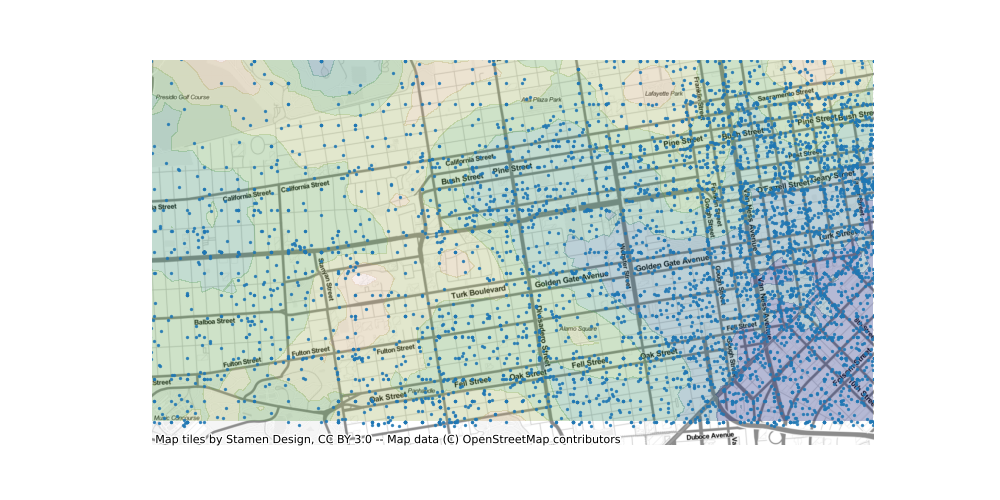

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_aspect('equal')
ax.set_axis_off()

ax.tricontourf(
    [p.x for p in lidar_mercator.geometry],
    [p.y for p in lidar_mercator.geometry],
    lidar_mercator.z,
    alpha=0.3,
    cmap='gist_earth'
)
cell_towers_mercator.plot(ax=ax, alpha=0.8, markersize=2)

cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite, zoom=15)

## Predicting RF propagation

Using the two tables `lidar` and `cell_towers`, we can use the User Defined Table Function (UDTF) `tf_rf_prop_max_signal` to train a model and predict signal power.

We are interested in the impact of doubling the number of antennas in the considered area. Since we have a finite list of antennas, we will emulate this by sampling half of the antennas at first. Then we will consider the complete dataset.

In [20]:
sql_query = """
SELECT * FROM TABLE(
  tf_rf_prop_max_signal(
    rf_source => CURSOR(
      SELECT repeater_id, lon, lat, elevation0 AS relative_elevation FROM cell_towers
    ),
    rf_source_z_is_relative_to_terrain => TRUE,
    rf_source_signal_strength_dbm => 20.0,
    rf_source_signal_frequency_mhz => 3900,
    terrain => CURSOR(
      (SELECT x , y, z FROM lidar)
    ),
    bin_dim_meters => 90,
    max_ray_travel_meters => 2000,
    num_rays_per_sources => 720,
    min_receiver_signal_strength_dbm => -100.0
  )
)
"""

In [ ]:
# NBVAL_SKIP
rf_prop = con.select_ipc(sql_query)

**TODO** 

Verify the above command: needs a specific flag to be available at compile time
For now, just load the results from a file

In [22]:
rf_prop = pd.read_parquet("s3://mapd-data/telco/RF_Prop_Output.parquet", storage_options={"anon": True})

In [23]:
rf_prop = gpd.GeoDataFrame(rf_prop, geometry=gpd.points_from_xy(rf_prop.x, rf_prop.y), crs=crs)

In [24]:
rf_prop.head(1)

,x,y,elevation,rf_source_id,max_rf_signal_strength_dbm,geometry
0,-122.42709,37.78296,47.555408,142065,-57.815292,POINT (-122.42709 37.78296)


## Visualizing the predicted signal power

In [25]:
rf_prop_mercator = rf_prop.to_crs(epsg=3857)

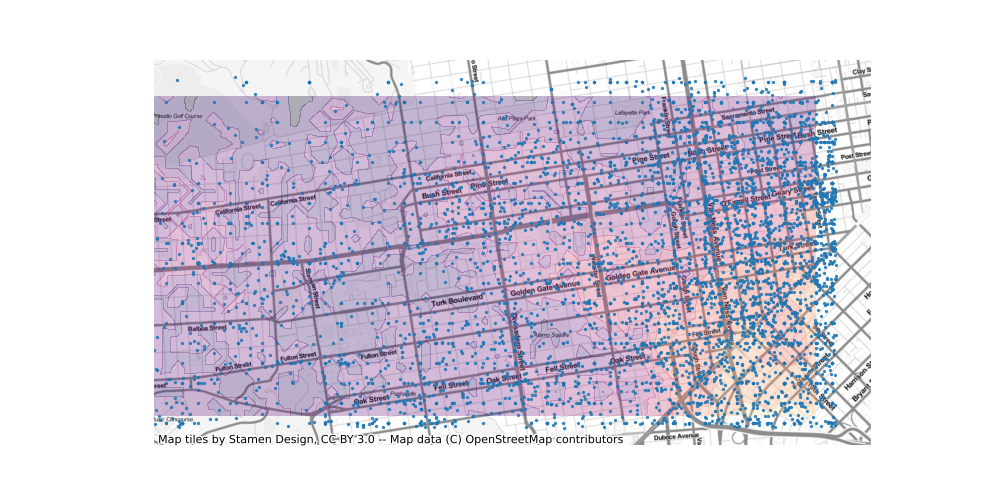

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))


ax.set_aspect('equal')
ax.set_axis_off()

ax.tricontourf(
    [p.x for p in rf_prop_mercator.geometry],
    [p.y for p in rf_prop_mercator.geometry],
    rf_prop_mercator.max_rf_signal_strength_dbm,
    alpha=0.3,
    cmap='magma'
)
cell_towers_mercator.plot(ax=ax, alpha=0.8, markersize=2)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite, zoom=15)

## Impact on the number of towers

Now let's randomly divide the number of towers by 10 and observe the impact on the RF propagation.

In [27]:
sql_query = """
SELECT * FROM TABLE(
  tf_rf_prop_max_signal(
    rf_source => CURSOR(
      SELECT repeater_id, lon, lat, elevation0 AS relative_elevation FROM cell_towers
      WHERE sample_ratio(0.5)
    ),
    rf_source_z_is_relative_to_terrain => TRUE,
    rf_source_signal_strength_dbm => 20.0,
    rf_source_signal_frequency_mhz => 3900,
    terrain => CURSOR(
      (SELECT x, y, z FROM lidar)
    ),
    bin_dim_meters => 90,
    max_ray_travel_meters => 2000,
    num_rays_per_sources => 720,
    min_receiver_signal_strength_dbm => -100.0
  )
)
"""

In [ ]:
# NBVAL_SKIP
rf_prop_half = con.select_ipc(sql_query)

**TODO**
Verify the above command: needs a specific flag to be available at compile time
For now, just load the results from a file

In [ ]:
rf_prop_half = pd.read_parquet("s3://mapd-data/telco/RF_Prop_Output.parquet", storage_options={"anon": True}).sample(frac=0.1)

In [ ]:
rf_prop_half = gpd.GeoDataFrame(rf_prop_half, geometry=gpd.points_from_xy(rf_prop_half.x, rf_prop_half.y), crs=crs)
rf_prop_mercator_half = rf_prop_half.to_crs(epsg=3857)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))


ax.set_aspect('equal')
ax.set_axis_off()

ax.tricontourf(
    [p.x for p in rf_prop_mercator_half.geometry],
    [p.y for p in rf_prop_mercator_half.geometry],
    rf_prop_mercator_half.max_rf_signal_strength_dbm,
    alpha=0.3,
    cmap='magma'
)
cell_towers_mercator.plot(ax=ax, alpha=0.8, markersize=2)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite, zoom=15)